# 信用评分风控分析

本notebook用于分析信用风险数据集，构建信用评分模型。

## 目录
1. 数据加载与探索
2. 数据预处理
3. 特征工程
4. 模型训练
5. 模型评估
6. 结果可视化


In [20]:
# 1. to handle the data
import pandas as pd
import numpy as np

# to visualize the dataset
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from pandas.plotting import parallel_coordinates

from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_curve, roc_auc_score

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import warnings
warnings.filterwarnings('ignore')

In [21]:
df = pd.read_csv('./dataset/credit_risk_dataset.csv')

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


可以看出存在缺失值问题：person_emp_length列有895个缺失值，loan_int_rate列有3116个缺失值，需要在建模前进行缺失值处理。

In [23]:
df.shape

(32581, 12)

In [24]:
df.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,31686.000000,32581.000000,29465.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.789686,9589.371106,11.011695,0.218164,0.170203,5.804211
std,6.348078,6.198312e+04,4.142630,6322.086646,3.240459,0.413006,0.106782,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


person_age最大值为144岁（明显异常），person_emp_length最大值为123年（不合理），loan_percent_income最大值为0.83（83%的贷款收入比过高），这些异常值会影响模型性能。

In [25]:
df.isnull().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

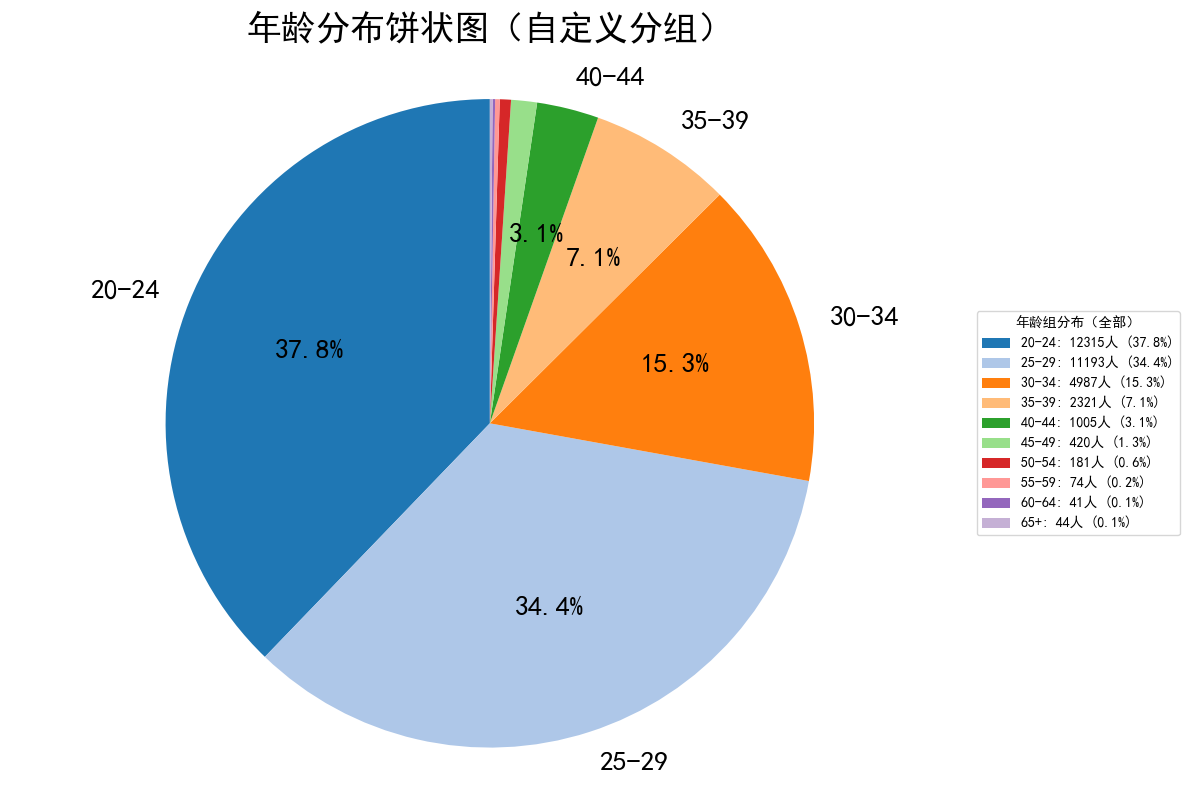

年龄分布统计:
20-24: 12315人 (37.8%)
25-29: 11193人 (34.4%)
30-34: 4987人 (15.3%)
35-39: 2321人 (7.1%)
40-44: 1005人 (3.1%)
45-49: 420人 (1.3%)
50-54: 181人 (0.6%)
55-59: 74人 (0.2%)
60-64: 41人 (0.1%)
65+: 44人 (0.1%)


In [35]:
# 根据CSV数据统计年龄分布饼状图（自定义年龄组）
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 加载数据（如果df尚未加载）
# df = pd.read_csv('dataset/credit_risk_dataset.csv')

# 创建年龄分组（15岁之前合并，65岁之后合并，中间5岁间隔）
bins = [20, 25, 30, 35, 40, 45, 50, 55, 60, 65, float('inf')]
labels = ['20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65+']
df['age_group'] = pd.cut(df['person_age'], bins=bins, labels=labels, right=False)

# 统计各年龄组的人数
age_counts = df['age_group'].value_counts().sort_index()

# 计算百分比
percentages = (age_counts.values / len(df)) * 100

# 创建饼状图
plt.figure(figsize=(12, 8))

# 使用更多颜色的colormap，并为每个部分分配鲜明对比色（避免相邻部分颜色太相似）
base_cmap = plt.cm.get_cmap('tab20')  # tab20 有20种鲜明颜色，适合分类避免相邻相似
num_groups = len(age_counts)
colors = [base_cmap(i % 20) for i in range(num_groups)]  # 循环使用，确保对比度高

# 如果需要进一步交错，可以手动调整顺序，但tab20已设计为相邻对比
# 或者使用ListedColormap自定义交错颜色列表（可选扩展）

# 自定义百分比显示函数 - 小于3%的不显示
def autopct_func(pct):
    if pct >= 3.0:
        return f'{pct:.1f}%'
    else:
        return ''

# 准备标签 - 小于3%的不显示标签
display_labels = [label if pct >= 3.0 else '' for label, pct in zip(age_counts.index, percentages)]

# 绘制饼状图
wedges, texts, autotexts = plt.pie(age_counts.values, 
                                   labels=display_labels,
                                   autopct=autopct_func,
                                   colors=colors,
                                   startangle=90,
                                   textprops={'fontsize': 20})

# 美化图表
plt.title('年龄分布饼状图（自定义分组）', fontsize=25, fontweight='bold', pad=20)
plt.axis('equal')

# 添加图例 - 显示全部年龄组
plt.legend(wedges, [f'{label}: {count}人 ({pct:.1f}%)' for label, count, pct in zip(age_counts.index, age_counts.values, percentages)],
           title="年龄组分布（全部）",
           loc="center left",
           bbox_to_anchor=(1, 0, 0.5, 1))

plt.tight_layout()
plt.show()

# 打印详细统计信息
print("年龄分布统计:")
print("=" * 50)
for age_group, count in age_counts.items():
    percentage = (count / len(df)) * 100
    print(f"{age_group}: {count}人 ({percentage:.1f}%)")

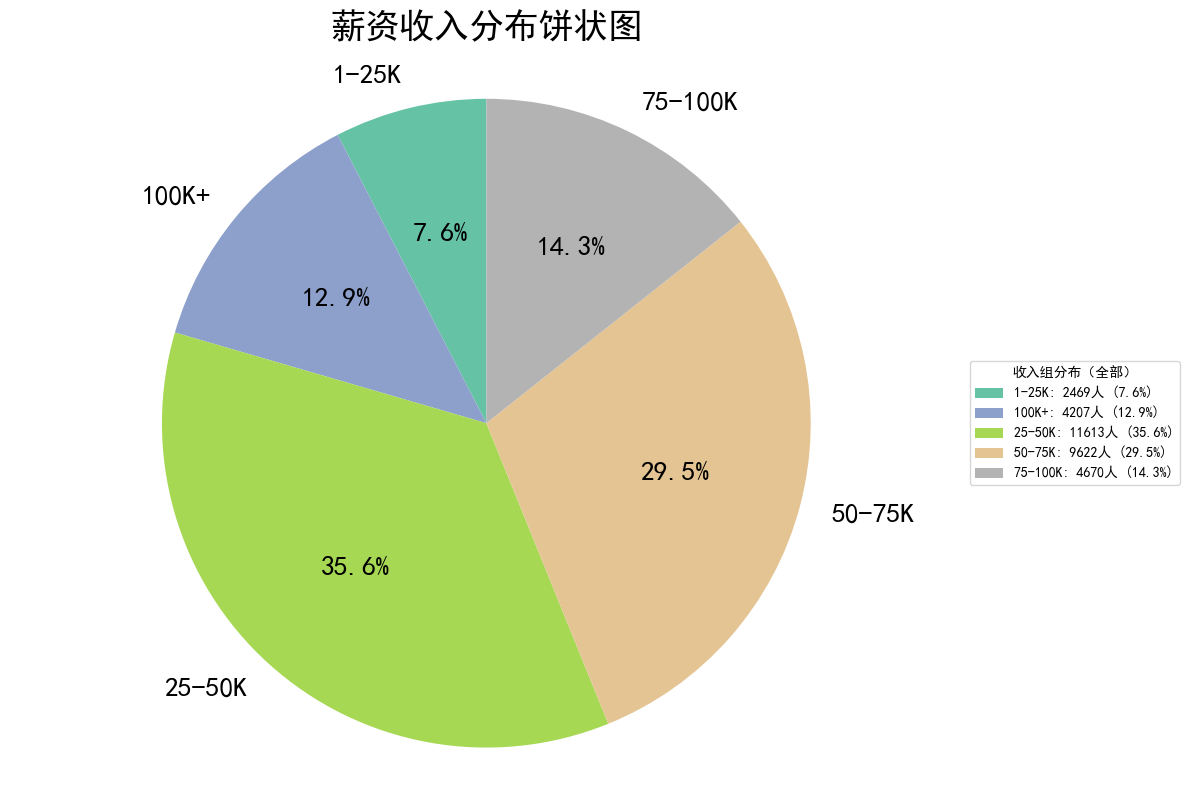

薪资收入分布统计:
1-25K: 2469人 (7.6%)
100K+: 4207人 (12.9%)
25-50K: 11613人 (35.6%)
50-75K: 9622人 (29.5%)
75-100K: 4670人 (14.3%)


In [29]:
# 根据CSV数据统计薪资收入分布饼状图（以K为单位）
import matplotlib.pyplot as plt
import numpy as np

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 加载数据
df = pd.read_csv('dataset/credit_risk_dataset.csv')

# 创建收入分组函数（以K为单位）
def create_income_groups(income):
    if income <= 25000:
        return '1-25K'
    elif income <= 50000:
        return '25-50K'
    elif income <= 75000:
        return '50-75K'
    elif income <= 100000:
        return '75-100K'
    else:
        return '100K+'

# 应用收入分组
df['income_group'] = df['person_income'].apply(create_income_groups)

# 统计各收入组的人数
income_counts = df['income_group'].value_counts().sort_index()

# 计算百分比
percentages = (income_counts.values / len(df)) * 100

# 创建饼状图
plt.figure(figsize=(12, 8))
colors = plt.cm.Set2(np.linspace(0, 1, len(income_counts)))

# 自定义百分比显示函数 - 小于3%的不显示
def autopct_func(pct):
    if pct >= 3.0:
        return f'{pct:.1f}%'
    else:
        return ''

# 准备标签 - 小于3%的不显示标签
labels = []
for label, pct in zip(income_counts.index, percentages):
    if pct >= 3.0:
        labels.append(label)
    else:
        labels.append('')  # 空标签

# 绘制饼状图
wedges, texts, autotexts = plt.pie(income_counts.values, 
                                   labels=labels,
                                   autopct=autopct_func,
                                   colors=colors,
                                   startangle=90,
                                   textprops={'fontsize': 20})

# 美化图表
plt.title('薪资收入分布饼状图', fontsize=25, fontweight='bold', pad=20)
plt.axis('equal')

# 添加图例 - 显示全部收入组
plt.legend(wedges, [f'{label}: {count}人 ({pct:.1f}%)' for label, count, pct in zip(income_counts.index, income_counts.values, percentages)],
          title="收入组分布（全部）",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.tight_layout()
plt.show()

# 打印详细统计信息
print("薪资收入分布统计:")
print("=" * 50)
for income_group, count in income_counts.items():
    percentage = (count / len(df)) * 100
    print(f"{income_group}: {count}人 ({percentage:.1f}%)")



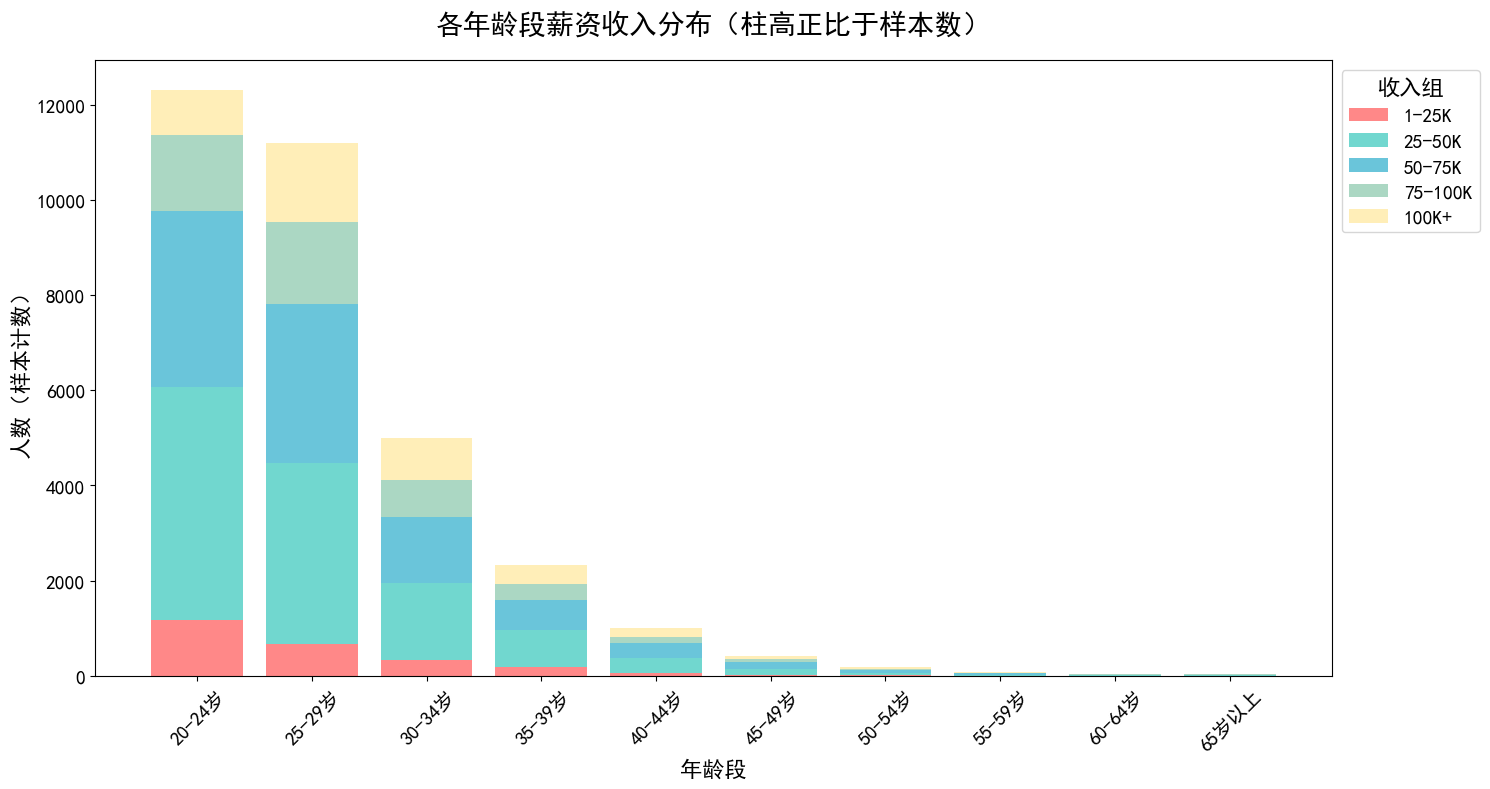

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 加载数据
df = pd.read_csv('dataset/credit_risk_dataset.csv')

# 创建年龄分组函数（5岁间隔）
def create_age_groups(age):
    if age < 25:
        return '20-24岁'
    elif age < 30:
        return '25-29岁'
    elif age < 35:
        return '30-34岁'
    elif age < 40:
        return '35-39岁'
    elif age < 45:
        return '40-44岁'
    elif age < 50:
        return '45-49岁'
    elif age < 55:
        return '50-54岁'
    elif age < 60:
        return '55-59岁'
    elif age < 65:
        return '60-64岁'
    else:
        return '65岁以上'

# 创建收入分组函数（以K为单位）
def create_income_groups(income):
    if income <= 25000:
        return '1-25K'
    elif income <= 50000:
        return '25-50K'
    elif income <= 75000:
        return '50-75K'
    elif income <= 100000:
        return '75-100K'
    else:
        return '100K+'

# 应用分组
df['age_group'] = df['person_age'].apply(create_age_groups)
df['income_group'] = df['person_income'].apply(create_income_groups)

# 计算每个年龄组和收入组的计数
counts = pd.crosstab(df['age_group'], df['income_group'])

# 按年龄组排序
age_order = ['20-24岁', '25-29岁', '30-34岁', '35-39岁', '40-44岁',
             '45-49岁', '50-54岁', '55-59岁', '60-64岁', '65岁以上']
counts = counts.reindex(age_order)

# 收入组顺序
income_order = ['1-25K', '25-50K', '50-75K', '75-100K', '100K+']
counts = counts[income_order]

# 计算每个年龄组的总人数（用于柱子高度）
age_totals = counts.sum(axis=1)

# 归一化为比例（用于后续如果需要，但绘图用计数）
proportions = counts.div(age_totals, axis=0) * 100

# 创建堆叠柱状图
plt.figure(figsize=(15, 8))

# 定义颜色
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7']

# 绘制堆叠柱状图（使用绝对计数作为高度）
bottom = np.zeros(len(counts))
for i, income_group in enumerate(income_order):
    plt.bar(range(len(counts)), counts[income_group],
            bottom=bottom, label=income_group, color=colors[i], alpha=0.8)
    bottom += counts[income_group]

# 美化图表（增大字体）
plt.title('各年龄段薪资收入分布（柱高正比于样本数）', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('年龄段', fontsize=16)
plt.ylabel('人数（样本计数）', fontsize=16)

# 设置x轴标签（增大字体）
plt.xticks(range(len(counts)), counts.index, rotation=45, fontsize=14)
plt.yticks(fontsize=14)

# 添加图例（增大字体）
plt.legend(title='收入组', title_fontsize=16, fontsize=14, loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

年轻年龄段（如20-24岁）样本量最大且中低收入（25-50K和50-75K）占比最高（约70%），而随着年龄增长，样本减少但高收入（100K+）比例逐渐上升，反映出职业发展与收入提升的正相关趋势。

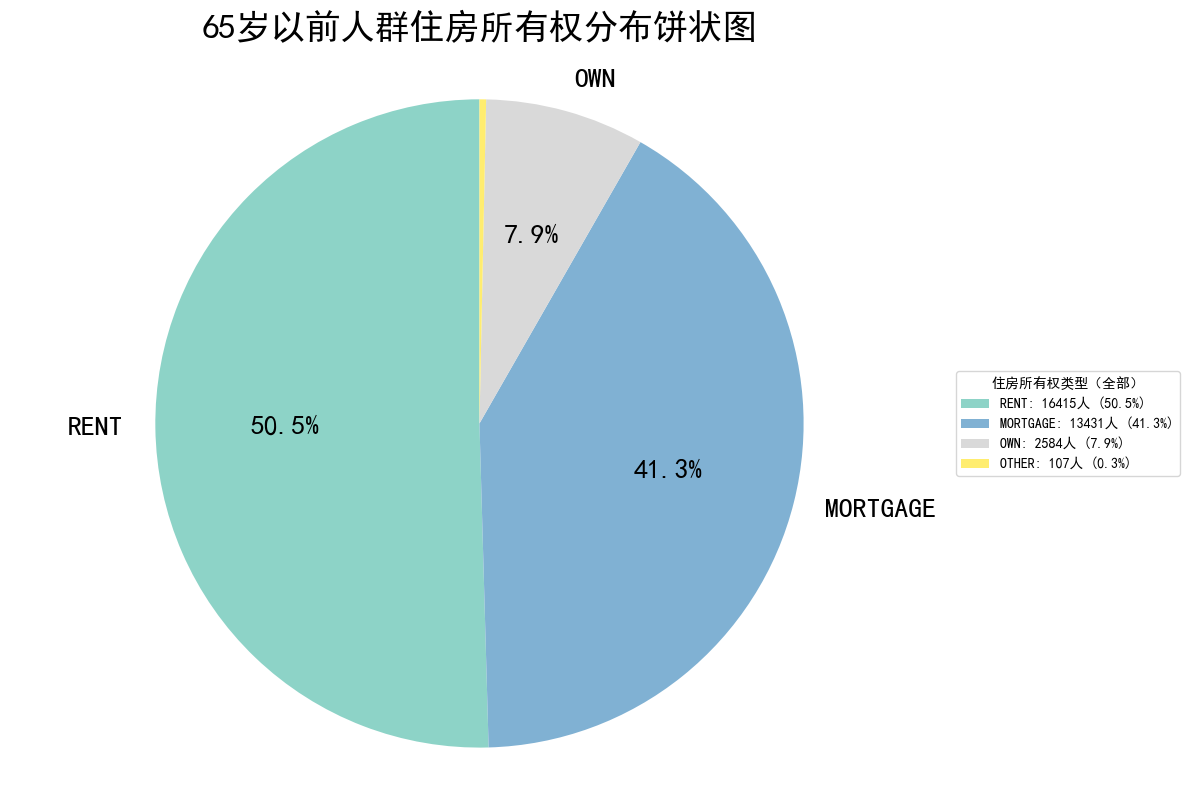

65岁以前人群住房所有权分布统计:
总人数: 32537人
平均年龄: 27.7岁

住房所有权分布:
RENT: 16415人 (50.5%)
MORTGAGE: 13431人 (41.3%)
OWN: 2584人 (7.9%)
OTHER: 107人 (0.3%)


In [ ]:
# 创建65岁以前人群住房所有权分布饼状图
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 加载数据
df = pd.read_csv('dataset/credit_risk_dataset.csv')

# 筛选65岁以前的人群
df_under65 = df[df['person_age'] < 65]

# 统计住房所有权分布
home_ownership_counts = df_under65['person_home_ownership'].value_counts()

# 计算百分比
percentages = (home_ownership_counts.values / len(df_under65)) * 100

# 创建饼状图
plt.figure(figsize=(12, 8))
colors = plt.cm.Set3(np.linspace(0, 1, len(home_ownership_counts)))

# 自定义百分比显示函数 - 小于3%的不显示
def autopct_func(pct):
    if pct >= 3.0:
        return f'{pct:.1f}%'
    else:
        return ''

# 准备标签 - 小于3%的不显示标签
labels = []
for label, pct in zip(home_ownership_counts.index, percentages):
    if pct >= 3.0:
        labels.append(label)
    else:
        labels.append('')  # 空标签

# 绘制饼状图
wedges, texts, autotexts = plt.pie(home_ownership_counts.values, 
                                   labels=labels,
                                   autopct=autopct_func,
                                   colors=colors,
                                   startangle=90,
                                   textprops={'fontsize': 20})

# 美化图表
plt.title('65岁以前人群住房所有权分布饼状图', fontsize=25, fontweight='bold', pad=20)
plt.axis('equal')

# 添加图例 - 显示全部住房类型
plt.legend(wedges, [f'{label}: {count}人 ({pct:.1f}%)' for label, count, pct in zip(home_ownership_counts.index, home_ownership_counts.values, percentages)],
          title="住房所有权类型（全部）",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.tight_layout()
plt.show()

# 打印详细统计信息
print("65岁以前人群住房所有权分布统计:")
print("=" * 50)
print(f"总人数: {len(df_under65)}人")
print(f"平均年龄: {df_under65['person_age'].mean():.1f}岁")
print("\n住房所有权分布:")
for home_type, count in home_ownership_counts.items():
    percentage = (count / len(df_under65)) * 100
    print(f"{home_type}: {count}人 ({percentage:.1f}%)")


65岁以前人群中租房占主导地位（50.5%），其次是抵押贷款购房（41.3%），自有住房仅占7.9%，反映出年轻人群的住房压力较大，多数人仍处于租房或还贷阶段。

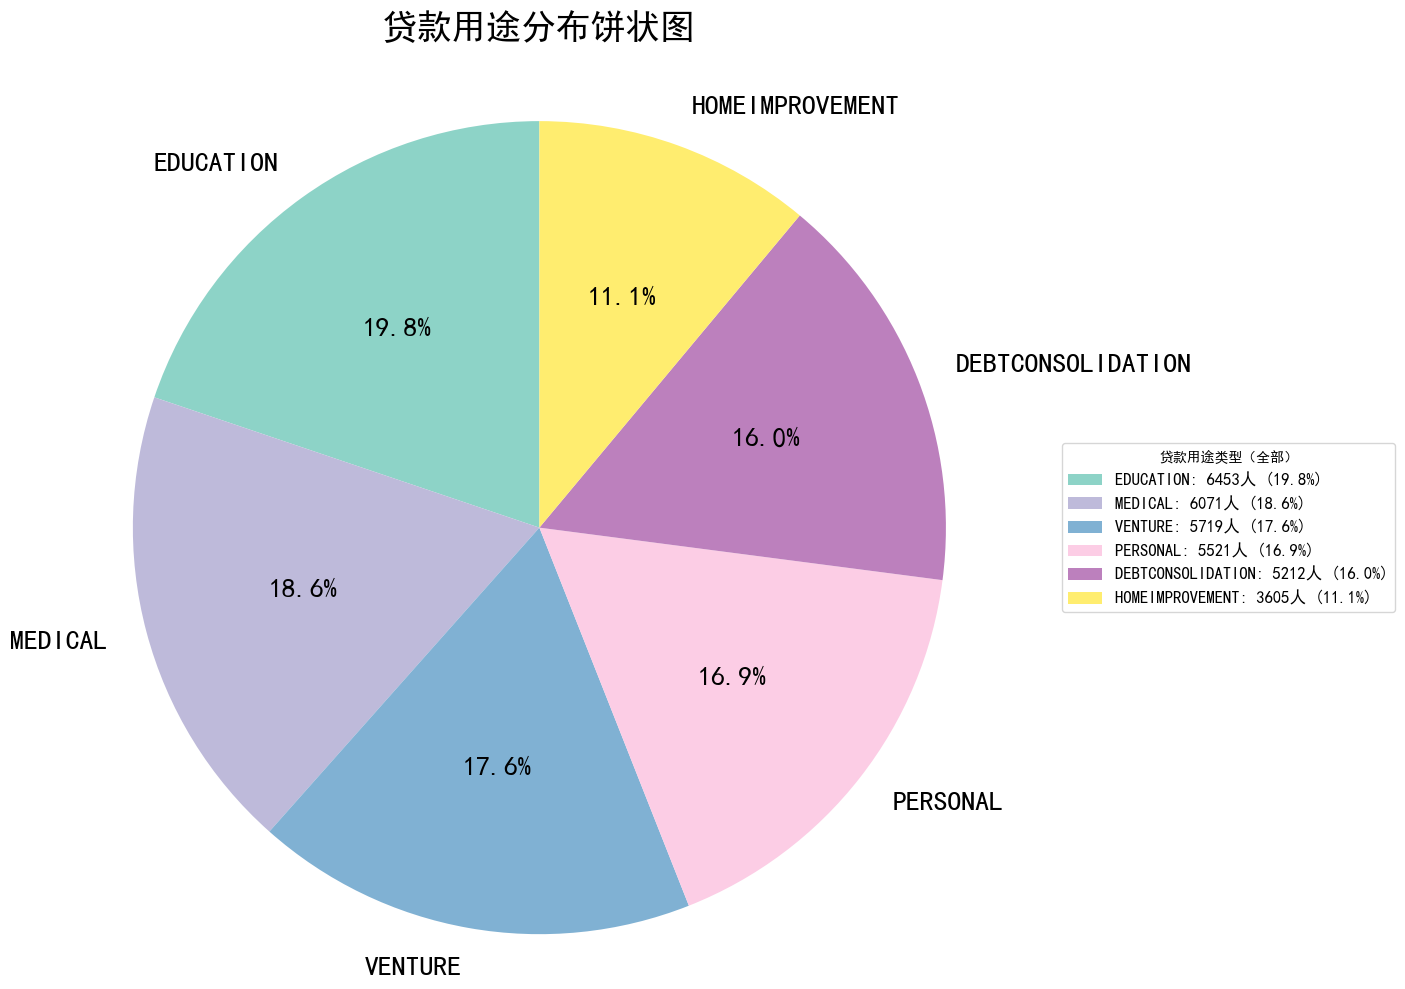

贷款用途分布统计:
总贷款数: 32581笔

贷款用途分布:
EDUCATION: 6453笔 (19.8%)
MEDICAL: 6071笔 (18.6%)
VENTURE: 5719笔 (17.6%)
PERSONAL: 5521笔 (16.9%)
DEBTCONSOLIDATION: 5212笔 (16.0%)
HOMEIMPROVEMENT: 3605笔 (11.1%)


In [19]:
# 创建贷款用途分布饼状图
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 加载数据
df = pd.read_csv('dataset/credit_risk_dataset.csv')

# 统计贷款用途分布
loan_intent_counts = df['loan_intent'].value_counts()

# 计算百分比
percentages = (loan_intent_counts.values / len(df)) * 100

# 创建饼状图
plt.figure(figsize=(14, 10))
colors = plt.cm.Set3(np.linspace(0, 1, len(loan_intent_counts)))

# 自定义百分比显示函数 - 小于3%的不显示
def autopct_func(pct):
    if pct >= 3.0:
        return f'{pct:.1f}%'
    else:
        return ''

# 准备标签 - 小于3%的不显示标签
labels = []
for label, pct in zip(loan_intent_counts.index, percentages):
    if pct >= 3.0:
        labels.append(label)
    else:
        labels.append('')  # 空标签

# 绘制饼状图
wedges, texts, autotexts = plt.pie(loan_intent_counts.values, 
                                   labels=labels,
                                   autopct=autopct_func,
                                   colors=colors,
                                   startangle=90,
                                   textprops={'fontsize': 20})  # 调大字体

# 美化图表
plt.title('贷款用途分布饼状图', fontsize=25, fontweight='bold', pad=30)  # 调大标题字体
plt.axis('equal')

# 添加图例 - 显示全部贷款用途
plt.legend(wedges, [f'{label}: {count}人 ({pct:.1f}%)' for label, count, pct in zip(loan_intent_counts.index, loan_intent_counts.values, percentages)],
          title="贷款用途类型（全部）",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1),
          fontsize=12)  # 调大图例字体

plt.tight_layout()
plt.show()

# 打印详细统计信息
print("贷款用途分布统计:")
print("=" * 60)
print(f"总贷款数: {len(df)}笔")
print("\n贷款用途分布:")
for intent, count in loan_intent_counts.items():
    percentage = (count / len(df)) * 100
    print(f"{intent}: {count}笔 ({percentage:.1f}%)")


贷款用途分布相对均衡，教育贷款占比最高（19.8%），医疗、创业、个人消费和债务整合各占16-18%

非数值列（将转换为数值）: ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
完整相关矩阵形状: (12, 12)
所有列名: ['person_age', 'person_income', 'person_home_ownership', 'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt', 'loan_int_rate', 'loan_status', 'loan_percent_income', 'cb_person_default_on_file', 'cb_person_cred_hist_length']


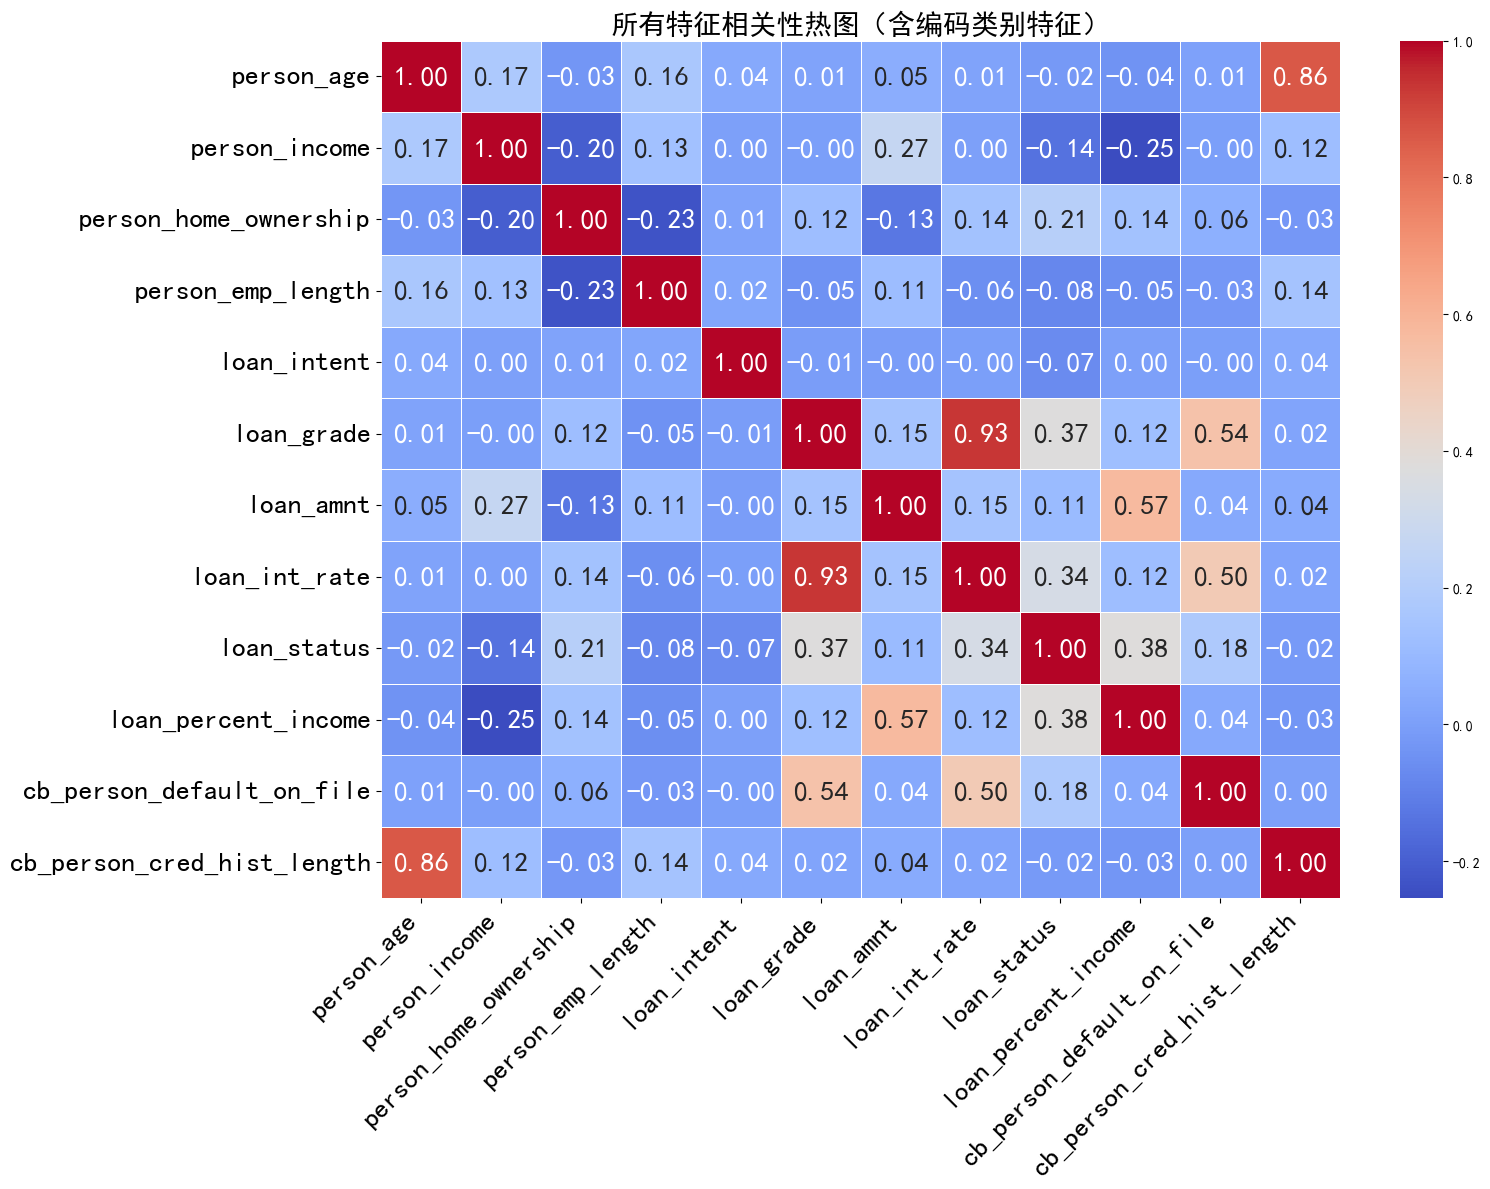

In [20]:
non_numeric_cols = df.select_dtypes(include=['object', 'category']).columns
print("非数值列（将转换为数值）:", non_numeric_cols.tolist())

# 使用LabelEncoder逐列转换（简单方式，适用于相关性分析）
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_encoded = df.copy()
for col in non_numeric_cols:
    df_encoded[col] = le.fit_transform(df[col].astype(str))  # astype(str) 处理NaN

# Step 2: 计算完整相关矩阵（现在所有列均为数值）
corr_matrix = df_encoded.corr()  # 无需numeric_only，所有列都数值化了

# Step 3: 打印矩阵形状和列名确认
print("完整相关矩阵形状:", corr_matrix.shape)
print("所有列名:", corr_matrix.columns.tolist())

# Step 4: 绘制热图（调整figsize以适应列数，例如如果13-14列，用(16,12)）
num_cols = corr_matrix.shape[0]
plt.figure(figsize=(16, 12))  # 根据实际列数调整更大以清晰显示
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, 
            linewidths=0.5, annot_kws={"size": 20})  # annot_kws减小注解字体避免拥挤
plt.title("所有特征相关性热图（含编码类别特征）", fontsize=20)
plt.xticks(rotation=45, ha='right', fontsize=20)
plt.yticks(rotation=0, fontsize=20)
plt.tight_layout()  # 防止标签裁剪
plt.show()


### 高相关性特征对（|r| > 0.7）
- **loan_grade（贷款等级）与loan_int_rate（贷款利率）**：相关性极高（0.934），说明贷款等级越高利率越低
- **person_age（年龄）与cb_person_cred_hist_length（信用历史长度）**：强相关（0.859），年龄越大信用历史越长

### 中等相关性特征对（0.3 < |r| < 0.7）
- **loan_status（违约状态）与loan_grade（贷款等级）**：正相关（0.373），低等级贷款违约风险更高
- **loan_status（违约状态）与loan_int_rate（贷款利率）**：正相关（0.335），高利率贷款违约风险更高
- **loan_status（违约状态）与loan_percent_income（贷款收入比）**：正相关（0.379），收入比越高违约风险越高
- **loan_grade（贷款等级）与cb_person_default_on_file（历史违约记录）**：正相关（0.537），低等级贷款与历史违约相关
- **loan_int_rate（贷款利率）与cb_person_default_on_file（历史违约记录）**：正相关（0.501），高利率与历史违约相关
- **loan_percent_income（贷款收入比）与loan_amnt（贷款金额）**：正相关（0.573），贷款金额与收入比例正相关

### 弱相关性特征对（0.1 < |r| < 0.3）
- **person_income（收入）与loan_status（违约状态）**：负相关（-0.144），收入越高违约风险越低
- **person_home_ownership（住房所有权）与loan_status（违约状态）**：正相关（0.212），租房者违约风险更高
- **person_income（收入）与loan_amnt（贷款金额）**：正相关（0.267），收入越高贷款金额越大
- **person_home_ownership（住房所有权）与person_income（收入）**：负相关（-0.203），收入高的人更可能拥有住房

In [6]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# 过滤：person_age < 80 且 person_emp_length < 70
df = df[(df['person_age'] < 80) & (df['person_emp_length'] < 70)]

# 处理缺失值
df.dropna(inplace=True)

# 定义列
feature_cols = [col for col in df.columns if col != 'loan_status']
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
if 'loan_status' in num_cols:
    num_cols.remove('loan_status')
cat_cols = [col for col in feature_cols if col not in num_cols]

# LabelEncoder 类别列
le_dict = {}
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    le_dict[col] = le

df_encoded = df.copy()

# 定义特征和目标
X = df_encoded.drop("loan_status", axis=1)
y = df_encoded["loan_status"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale 数值列
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

In [7]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

xgb = XGBClassifier(eval_metric="logloss", random_state=42)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [8]:

results = []

for name, model in [("Logistic Regression", log_reg),
                    ("Decision Tree", dt),
                    ("Random Forest", rf),
                    ("XGBoost", xgb)]:
    
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else None
    
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_prob) if y_prob is not None else None
    })

df_results = pd.DataFrame(results)
print(df_results)

                 Model  Accuracy  Precision    Recall  F1-Score   ROC-AUC
0  Logistic Regression  0.844219   0.707637  0.478226  0.570741  0.852183
1        Decision Tree  0.884212   0.719058  0.763710  0.740712  0.840615
2        Random Forest  0.931016   0.947090  0.721774  0.819222  0.932958
3              XGBoost  0.937129   0.939122  0.758871  0.839429  0.948070


In [33]:
param_dist = {
    'n_estimators': [100, 150, 200, 300],
    'max_depth': [3, 5, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

random_search = RandomizedSearchCV(
    xgb, param_distributions=param_dist, 
    n_iter=50, cv=5, scoring='accuracy', 
    random_state=42, n_jobs=-1
)

random_search.fit(X_train, y_train)

print("Best XGBoost Params:", random_search.best_params_)
print("Best XGBoost Score:", random_search.best_score_)
best_xgb_model = random_search.best_estimator_
best_model = random_search.best_estimator_
print(type(best_model).__name__)

Best XGBoost Params: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
Best XGBoost Score: 0.9348147417327504
XGBClassifier


In [15]:
import optuna
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, recall_score

def objective(trial):
    param_dist = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'subsample': trial.suggest_categorical('subsample', [0.6, 0.8, 1.0]),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.6, 0.8, 1.0]),
        'random_state': 42,
        'use_label_encoder': False,
        'eval_metric': 'logloss'
    }
    
    xgb = XGBClassifier(**param_dist)
    
    # 使用交叉验证计算准确率作为优化目标
    score = cross_val_score(xgb, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1).mean()
    
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Best XGBoost Params:", study.best_params)
print("Best XGBoost CV Accuracy:", study.best_value)

best_params = study.best_params
best_xgb_model = XGBClassifier(**best_params, random_state=42, use_label_encoder=False, eval_metric='logloss')
best_xgb_model.fit(X_train, y_train)

y_pred = best_xgb_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)

print("Test Accuracy:", test_accuracy)
print("Test Recall:", test_recall)
print(type(best_xgb_model).__name__)

[I 2025-10-15 14:18:49,897] A new study created in memory with name: no-name-b3c009b0-d926-45fc-aec4-72940a080d6b
[I 2025-10-15 14:18:50,482] Trial 0 finished with value: 0.9325443425426266 and parameters: {'n_estimators': 155, 'max_depth': 5, 'learning_rate': 0.14572024768759892, 'subsample': 0.6, 'colsample_bytree': 0.6}. Best is trial 0 with value: 0.9325443425426266.
[I 2025-10-15 14:18:51,274] Trial 1 finished with value: 0.9333302829515114 and parameters: {'n_estimators': 281, 'max_depth': 7, 'learning_rate': 0.02507119742976453, 'subsample': 0.8, 'colsample_bytree': 0.8}. Best is trial 1 with value: 0.9333302829515114.
[I 2025-10-15 14:18:52,084] Trial 2 finished with value: 0.9323260972557049 and parameters: {'n_estimators': 293, 'max_depth': 6, 'learning_rate': 0.12182115350627752, 'subsample': 0.6, 'colsample_bytree': 1.0}. Best is trial 1 with value: 0.9333302829515114.
[I 2025-10-15 14:18:52,623] Trial 3 finished with value: 0.9322823147441157 and parameters: {'n_estimators

Best XGBoost Params: {'n_estimators': 127, 'max_depth': 7, 'learning_rate': 0.13832280115978918, 'subsample': 1.0, 'colsample_bytree': 1.0}
Best XGBoost CV Accuracy: 0.9352950243506261
Test Accuracy: 0.9393992315752707
Test Recall: 0.7475806451612903
XGBClassifier


In [13]:
import optuna
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, recall_score
from tqdm import tqdm
import numpy as np

def objective(trial):
    param_dist = {
        'hidden_layer_sizes': trial.suggest_categorical('hidden_layer_sizes', [(50,), (100,), (50, 50)]),
        'activation': trial.suggest_categorical('activation', ['relu', 'tanh']),
        'learning_rate_init': trial.suggest_float('learning_rate_init', 0.001, 0.1, log=True),
        'max_iter': trial.suggest_int('max_iter', 200, 500),
        'alpha': trial.suggest_float('alpha', 1e-5, 1e-2, log=True),
        'random_state': 42
    }
    
    mlp = MLPClassifier(**param_dist)
    
    # 使用交叉验证计算准确率作为优化目标
    score = cross_val_score(mlp, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1).mean()
    
    return score

study = optuna.create_study(direction='maximize')

pbar = tqdm(total=50, desc="Optuna Trials")

def callback(study, trial):
    pbar.update(1)
    pbar.set_postfix({"Best Value": study.best_value})

study.optimize(objective, n_trials=50, callbacks=[callback])
pbar.close()

print("Best MLP Params:", study.best_params)
print("Best MLP CV Accuracy:", study.best_value)

best_params = study.best_params
best_mlp_model = MLPClassifier(**best_params, random_state=42)
best_mlp_model.fit(X_train, y_train)

y_pred = best_mlp_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)

print("Test Accuracy:", test_accuracy)
print("Test Recall:", test_recall)
print(type(best_mlp_model).__name__)

[I 2025-10-15 14:11:04,889] A new study created in memory with name: no-name-63707730-0693-4898-9978-9f54ee3068d8
Optuna Trials: 100%|██████████| 50/50 [03:19<00:00,  3.99s/it, Best Value=0.921]


Best MLP Params: {'hidden_layer_sizes': (50, 50), 'activation': 'relu', 'learning_rate_init': 0.028148949794916348, 'max_iter': 396, 'alpha': 0.006697094420749218}
Best MLP CV Accuracy: 0.9208870605662843
Test Accuracy: 0.9250785888927698
Test Recall: 0.6959677419354838
MLPClassifier


In [14]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, recall_score

def objective(trial):
    param_dist = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 4),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'random_state': 42
    }
    
    rf = RandomForestClassifier(**param_dist)
    
    # 使用交叉验证计算准确率作为优化目标
    score = cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1).mean()
    
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Best RandomForest Params:", study.best_params)
print("Best RandomForest CV Accuracy:", study.best_value)

best_params = study.best_params
best_rf_model = RandomForestClassifier(**best_params, random_state=42)
best_rf_model.fit(X_train, y_train)

y_pred = best_rf_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)

print("Test Accuracy:", test_accuracy)
print("Test Recall:", test_recall)
print(type(best_rf_model).__name__)

[I 2025-10-15 14:16:52,023] A new study created in memory with name: no-name-e2ddafe3-7cac-4a67-9fcd-8736bf4cacf9
[I 2025-10-15 14:16:54,400] Trial 0 finished with value: 0.927785413264776 and parameters: {'n_estimators': 176, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.927785413264776.
[I 2025-10-15 14:16:56,955] Trial 1 finished with value: 0.9273050448549114 and parameters: {'n_estimators': 245, 'max_depth': 14, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 0 with value: 0.927785413264776.
[I 2025-10-15 14:16:59,382] Trial 2 finished with value: 0.9280472694793094 and parameters: {'n_estimators': 210, 'max_depth': 17, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.9280472694793094.
[I 2025-10-15 14:17:00,967] Trial 3 finished with value: 0.9266501850723845 and parameters: {'n_estimators': 146, 'max_depth': 15, 'min

Best RandomForest Params: {'n_estimators': 184, 'max_depth': 19, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt'}
Best RandomForest CV Accuracy: 0.9282656482204358
Test Accuracy: 0.9327628361858191
Test Recall: 0.7185483870967742
RandomForestClassifier


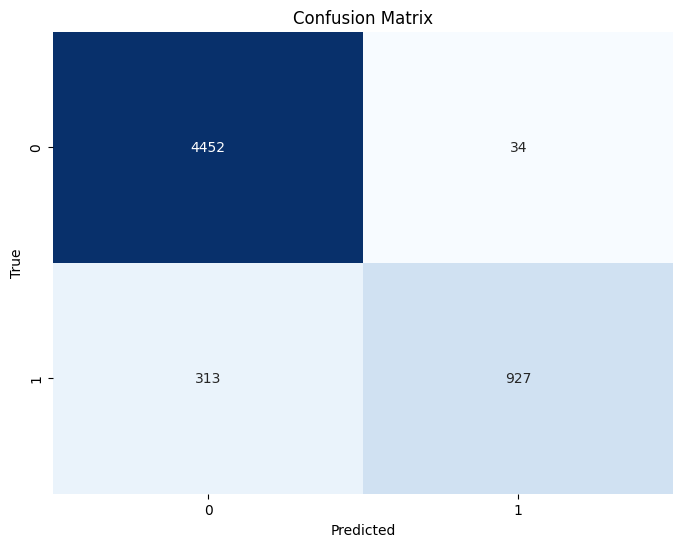

In [16]:
cm = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

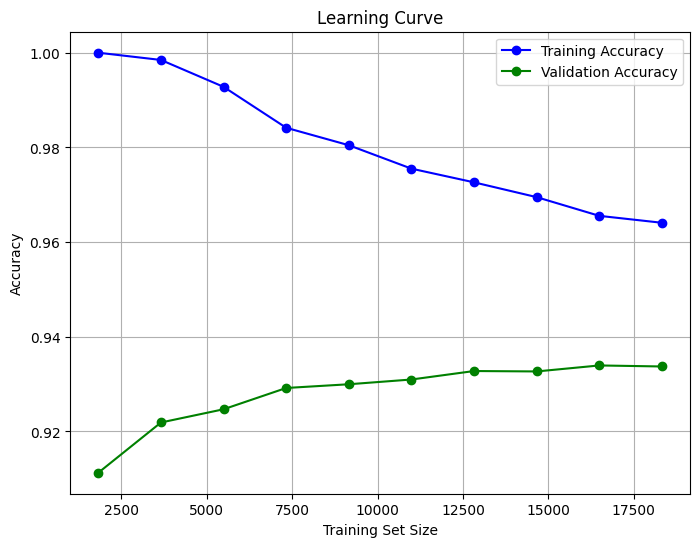

In [17]:
train_sizes, train_scores, test_scores = learning_curve(
    model, X_train, y_train, cv=5, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Accuracy')
plt.plot(train_sizes, test_mean, 'o-', color='green', label='Validation Accuracy')
plt.title('Learning Curve')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.show()

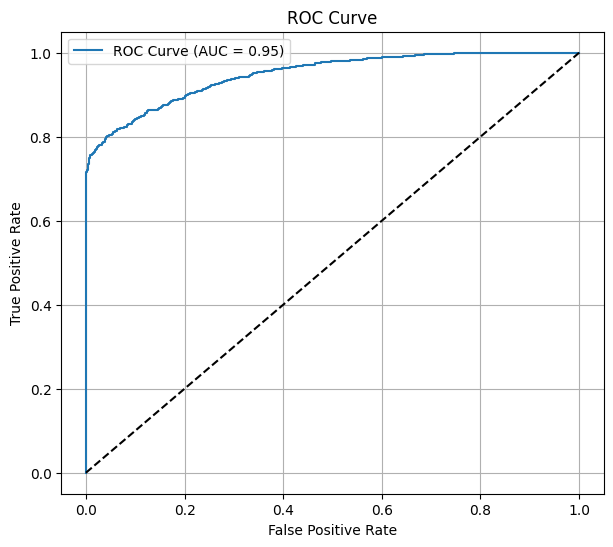

In [18]:
y_pred_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.grid(True)
plt.show()